### Monthly PSI Monitoring
---

In [1]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r requirements.txt --use-deprecated=legacy-resolver

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from smart_open import open
import pickle as pkl
import datetime as dt

import src.monitoring.refit as refit
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# modify this whenever we modify the model
prod_df_path_prev = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-09/prev_test_df.parquet"
model_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"

In [3]:
today_str = str(dt.date.today())
YYYYMM = "-".join(today_str.split("-")[:2])
output_dir = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{YYYYMM}"
prod_df_path = os.path.join(output_dir, f"prod-data-{today_str}.parquet")
print(prod_df_path)

s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-12/prod-data-2021-12-02.parquet


#### load previous data

In [5]:
prod_df_prev = pd.read_parquet(prod_df_path_prev)

2020-01-01    167293
Name: sample_date, dtype: int64


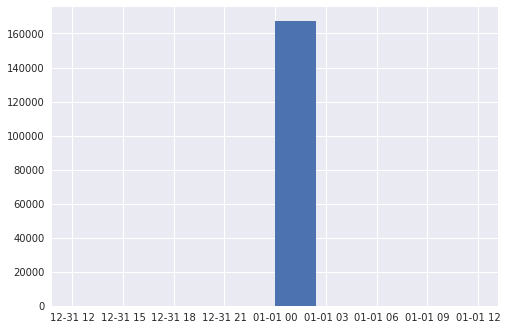

In [6]:
prod_df_prev.sample_date.hist()
print(prod_df_prev.sample_date.value_counts())

#### load current data

In [6]:
!pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple sofiproto==release-1703 s3fs
!pip install read_protobuf

Looking in indexes: https://build.sofi.com/artifactory/api/pypi/pypi/simple
     |████████████████████████████████| 8.1 MB 67.9 MB/s            
  Attempting uninstall: botocore
    Found existing installation: botocore 1.21.0
    Uninstalling botocore-1.21.0:
      Successfully uninstalled botocore-1.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.20.18 requires botocore<1.24.0,>=1.23.18, but you have botocore 1.22.8 which is incompatible.


#### Load Prev Prod data from S3

#### Query Current Prod Data

In [4]:
sys.path.insert(1, "../..")
from src.monitoring.download_customer_prod import download_customer_prod_data

download_customer_prod_data(prod_df_path)

querying money user data...
some data processing...


In [5]:
prod_df = pd.read_parquet(prod_df_path)
prod_df.shape

(1793290, 56)

In [6]:
# process prod df, and jog down some stats to make sure things are correct
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,transaction_as_pct_of_balance,dollar_val_dd,pct_returned_deposits,time_since_last_transaction,dollar_val_returns,nr_trans_ratio,giact_time_since_last_link,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,1864,2021-08-18 02:05:59.086,2021-12-01 03:09:46.862,2021-12-01 03:09:46.861,2021-12-01 03:09:46.861,"""RG2A""","""scheduled""",529.771737,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG2A""",...,0.000000,0.0,0.0,-1.0,0.0,-1.000000,-1.0,0,-1.0,-1.0
1,11837,2021-08-27 18:36:21.149,2021-09-01 03:33:10.891,2021-08-27 18:36:21.147,2021-08-27 18:36:21.147,"""RG4A""","""onboarding""",637.853798,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG4A""",...,0.000000,0.0,0.0,-1.0,0.0,-1.000000,-1.0,0,-1.0,-1.0
2,13240,2020-08-05 06:12:33.971,2021-12-01 03:04:22.668,2021-12-01 03:04:22.667,2021-12-01 03:04:22.667,"""RG1""","""scheduled""",485.761886,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.000000,0.0,0.0,-1.0,0.0,-1.000000,-1.0,0,-1.0,-1.0
3,14014,2021-05-05 02:08:42.539,2021-12-01 03:09:20.529,2021-12-01 03:09:20.528,2021-12-01 03:09:20.528,"""RG2B""","""scheduled""",535.544806,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG2B""",...,2.645503,0.0,0.0,14.0,0.0,-1.000000,-1.0,4,-1.0,-1.0
4,20202,2020-08-05 06:24:54.015,2021-12-01 03:07:22.433,2021-12-01 03:07:22.431,2021-12-01 03:07:22.431,"""RG1""","""scheduled""",377.813083,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.289519,0.0,0.0,10.0,0.0,0.333333,-1.0,4,-1.0,-1.0


<AxesSubplot:>

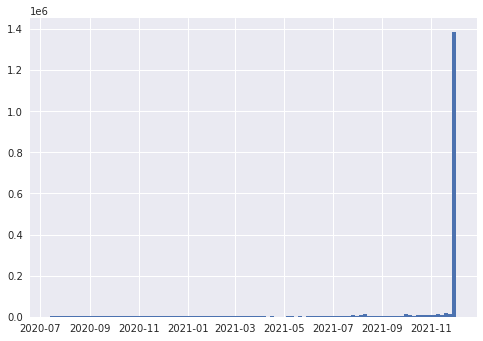

In [7]:
pd.to_datetime(prod_df["last_checked_date"]).hist(bins=100)

<AxesSubplot:>

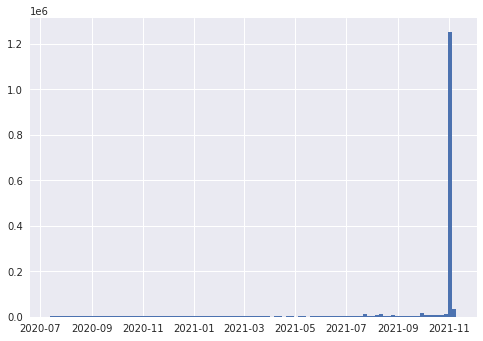

In [8]:
pd.to_datetime(prod_df["last_checked_date"]).hist(bins=100)

#### preprocess and generate model score

In [11]:
# with open(model_path, "rb") as f:
#     customer_model = pkl.load(f)

In [12]:
# !pip uninstall numpy -y
# !pip install numpy==1.20.0 --no-cache-dir

Found existing installation: numpy 1.21.4
Uninstalling numpy-1.21.4:
  Successfully uninstalled numpy-1.21.4
     |████████████████████████████████| 15.3 MB 3.3 MB/s            


#### save to s3

In [ ]:
# prod_df_prev.to_parquet(os.path.join(output_dir, f"prev_test_df.parquet"))
# prod_df.to_parquet(prod_df_path)

In [18]:
prod_df_path

's3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-11/prod-data-2021-11-09.parquet'